# Imports

In [172]:
import pandas as pd
import numpy as np

from mamimo.time_utils import add_time_features, PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation, BoxCoxSaturation

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import scipy.stats as stats
import statsmodels.api as sm

import holidays

import seaborn as sns
import matplotlib.pyplot as plt

# Load DataFrame

In [173]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

In [174]:
df

,orders,total_sales,facebook,google,tiktok,day
Day,,,,,,
2021-07-01,10,414.85,257.01,1.17,0.00,2021-07-01
2021-07-02,6,229.95,250.30,0.84,0.00,2021-07-02
2021-07-03,10,459.89,248.59,0.72,0.00,2021-07-03
2021-07-04,17,508.36,258.05,0.07,0.00,2021-07-04
2021-07-05,13,399.88,257.47,0.38,0.00,2021-07-05
...,...,...,...,...,...,...
2023-08-20,294,13616.97,2148.53,466.56,368.86,2023-08-20
2023-08-21,356,15348.42,2210.01,400.58,391.14,2023-08-21
2023-08-22,150,6054.53,1335.84,289.46,218.61,2023-08-22


<Axes: xlabel='google', ylabel='Count'>

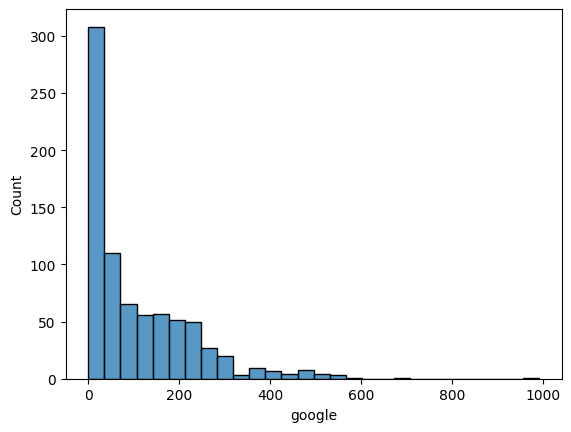

In [175]:
sns.histplot(data=df, x='google')

# Split Data

In [176]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]



y_train = train_df['total_sales']
X_train = train_df.drop(columns = ['total_sales', 'orders'])


y_test = test_df['total_sales']
X_test = test_df.drop(columns = ['total_sales', 'orders'])

# Baseline Model

In [177]:
baseline = train_df.shift(1) # baseline['total_sales'] is equivalent to y_pred

y_pred = baseline['total_sales']
y_true = train_df['total_sales']

# MSE
mse = ((y_true - y_pred) ** 2).mean()

# Calculate TSS (Total Sum of Squares)
mean_y_true = np.mean(y_true)
tss = np.sum((y_true - mean_y_true)**2)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_true - y_pred)**2)

# Calculate R-squared (Coefficient of Determination)
r_squared = 1 - (rss / tss)

f"{mse} is our MSE to beat; {r_squared} is our R squared to beat!"

'595453.442743578 is our MSE to beat; 0.6398209085770498 is our R squared to beat!'

In [178]:
y_pred = train_df['total_sales'].mean()
y_true = train_df['total_sales']

# MSE
mse = ((y_true - y_pred) ** 2).mean()

# Calculate TSS (Total Sum of Squares)
mean_y_true = np.mean(y_true)
tss = np.sum((y_true - mean_y_true)**2)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_true - y_pred)**2)

# Calculate R-squared (Coefficient of Determination)
r_squared = 1 - (rss / tss)

f"{mse} is our MSE to beat; {r_squared} is our R squared to beat!"

'1650690.9137039694 is our MSE to beat; 0.0 is our R squared to beat!'

# Check for stationarity

In [179]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df.total_sales)[1] # close enough to 0.05, so our data is stationary enough

0.062198848540433505

# Create Custom Tranformers

## Time Features

### Holidays

In [180]:
class AddHolidaysTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        de_holiday_list = []
        for holiday in holidays.Germany(years=[2021,2022,2023]).items():
            de_holiday_list.append(holiday)
        de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
        de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
        de_holidays_df.set_index('date', inplace=True)
        
        at_holiday_list = []
        for holiday in holidays.Austria(years=[2021,2022,2023]).items():
            at_holiday_list.append(holiday)
        at_holidays_df = pd.DataFrame(at_holiday_list, columns=["date", "holiday"])
        at_holidays_df['date'] = pd.to_datetime(at_holidays_df['date'])
        at_holidays_df.set_index('date', inplace=True)

        # add DE holidays to df
        merged_df = df.merge(de_holidays_df, how='left', left_index=True, right_index=True)
        merged_df['de_holiday'] = merged_df.index.isin(de_holidays_df.index).astype(int)
        merged_df.drop(columns=['holiday'], inplace=True)
        
        # add AT holidays to df
        at_holidays_df['at_holiday'] = 1 # add a 1 column to austrian holidays dataframe to help us merge with DE holidays
        merged_df = merged_df.merge(at_holidays_df[['at_holiday']], how='left', left_index=True, right_index=True)
        merged_df.head() # creates two columns (at_holiday_x, at_holiday_y), we only need one
        merged_df['at_holiday'].fillna(0, inplace=True) # replace NaN (no holiday) with 0
        merged_df['at_holiday'] = merged_df['at_holiday'].astype(int) # convert 1 and 0 to integers
        
        # combine columns
        merged_df['holiday'] = (merged_df['at_holiday'] | merged_df['de_holiday']).astype(int)
        merged_df = merged_df.drop(columns = ['de_holiday', 'at_holiday']) # drop individual DE and AT rows
        
        return merged_df[['holiday']]#.reset_index(drop=True)


#### Does it work?

In [181]:
holidays_transformer = AddHolidaysTransformer()
df = train_df.copy()
holidays_transformer.fit_transform(df)

,holiday
Day,
2021-07-01,0
2021-07-02,0
2021-07-03,0
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,0


#### Yes!

### Weekends

In [182]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

#### Does it work?

In [183]:
weekends_transformer = AddWeekendsTransformer()
df = train_df.copy()
weekends_transformer.fit_transform(df)

,fri_sat
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,1
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,1


#### Yes!

### Cyclical months

In [184]:
class AddMonthsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df = (df
        .pipe(add_time_features, month=True)
        )
        
        months_in_a_year = 12

        df['sin_MonthYear'] = np.sin(2*np.pi*(df['month'])/months_in_a_year)
        df['cos_MonthYear'] = np.cos(2*np.pi*(df['month'])/months_in_a_year)
        df.drop(columns=['month'], inplace=True)
        
        return df[['sin_MonthYear', 'cos_MonthYear']]

#### Does it work?

In [185]:
add_months_transformer = AddMonthsTransformer()
df = train_df.copy()
add_months_transformer.fit_transform(df)

,sin_MonthYear,cos_MonthYear
Day,,
2021-07-01,-0.500000,-0.866025
2021-07-02,-0.500000,-0.866025
2021-07-03,-0.500000,-0.866025
2021-07-04,-0.500000,-0.866025
2021-07-05,-0.500000,-0.866025
...,...,...
2023-04-12,0.866025,-0.500000
2023-04-13,0.866025,-0.500000
2023-04-14,0.866025,-0.500000


#### Yes!

### Power Trend

In [186]:
class AddTrendTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, power=1):
        self.power = power
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly

        df['trend'] = PowerTrend(self.power).fit_transform(df[['trend']])
        
        return df[['trend']]

#### Does it work?

#### Yes!

## Sales Features

### Lag

In [188]:
class AddSalesLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=7):
        self.period = period

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales lag column with the specified period."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_lag'] = df['total_sales'].shift(self.period)
        df['sales_lag'] = df['sales_lag'].bfill()  # Backfill missing values
        return df[['sales_lag']]


In [189]:
sales_lag_transformer = AddSalesLagTransformer(period = 7)
df = train_df.copy()
sales_lag_transformer.fit_transform(df)

,sales_lag
Day,
2021-07-01,414.85
2021-07-02,414.85
2021-07-03,414.85
2021-07-04,414.85
2021-07-05,414.85
...,...
2023-04-12,3173.95
2023-04-13,1865.47
2023-04-14,2133.27


### Moving Average

In [190]:
class AddSalesMovAvgTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=7):
        self.window_size = window_size

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales moving average column. Indicate the window size (default = 7)"""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_moving_avg'] = df['total_sales'].rolling(window=self.window_size, center=True).mean()
        df['sales_moving_avg'] = df['sales_moving_avg'].bfill()  # Backfill missing values at beginning of df
        df['sales_moving_avg'] = df['sales_moving_avg'].ffill()  # Forwardfill missing values at end of df
        return df[['sales_moving_avg']]

#### Does it work?

In [191]:
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
df = train_df.copy()
sales_mov_avg_transformer.fit_transform(df)

,sales_moving_avg
Day,
2021-07-01,407.245714
2021-07-02,407.245714
2021-07-03,407.245714
2021-07-04,407.245714
2021-07-05,445.885714
...,...
2023-04-12,3026.895714
2023-04-13,3237.397143
2023-04-14,3237.397143


In [192]:
sales_df = sales_mov_avg_transformer.fit_transform(df)
sales_df['total_sales'] = train_df['total_sales']
sales_df

,sales_moving_avg,total_sales
Day,,
2021-07-01,407.245714,414.85
2021-07-02,407.245714,229.95
2021-07-03,407.245714,459.89
2021-07-04,407.245714,508.36
2021-07-05,445.885714,399.88
...,...,...
2023-04-12,3026.895714,3718.12
2023-04-13,3237.397143,2913.63
2023-04-14,3237.397143,1735.46


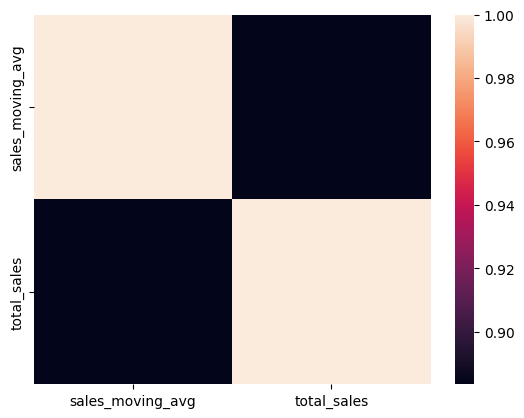

In [193]:
sns.heatmap(sales_df.corr());

#### Yes!

### Exponential Smoothing

In [194]:
class AddSalesExpSmoothingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Adds a sales (exponential smoothing) column. Indicate the alpha value (default = 0.5)"""
        df = X.copy()
        smoothed_series = [df['total_sales'].iloc[0]]
        for i in range(1, len(df)):
            smoothed_value = self.alpha * df['total_sales'].iloc[i] + (1 - self.alpha) * smoothed_series[-1]
            smoothed_series.append(smoothed_value)
        df['smoothed_sales'] = smoothed_series
        return df[['smoothed_sales']]

#### Does it work?

In [195]:
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)
df = train_df.copy()
sales_exp_smoothing_transformer.fit_transform(df)

,smoothed_sales
Day,
2021-07-01,414.850000
2021-07-02,322.400000
2021-07-03,391.145000
2021-07-04,449.752500
2021-07-05,424.816250
...,...
2023-04-12,3845.153512
2023-04-13,3379.391756
2023-04-14,2557.425878


#### Yes!

## Adstock
* comes from `mamimo` package, explained [here](https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6)

In [196]:
adstock = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['tiktok'])
])

def create_df(array: np.array):
    columns = ['orders', 'total_sales', 'facebook', 'google', 'tiktok', 'holiday',
       'fri_sat', 'sin_MonthYear', 'cos_MonthYear',
       'google_cumulative', 'tiktok_cumulative', 'facebook_cumulative',
       'sales_lag', 'sales_moving_avg', 'smoothed_sales']
    columns_ = ['facebook','google','tiktok']
    df = pd.DataFrame(array, columns = columns_)
    datetime_series = pd.Series(
        pd.date_range("2021-07-01", periods=len(df), freq="D")
        )
    df = pd.concat([df,datetime_series],axis=1)
    df = df.set_index(0)
    df = df.rename(index={0: 'Day'})
    return df

# Instantiate Custom Transformers

In [197]:
holidays_transformer = AddHolidaysTransformer()
weekends_transformer = AddWeekendsTransformer()
add_months_transformer = AddMonthsTransformer()
add_trend_transformer = AddTrendTransformer()


sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

# Debug CT

## Time CT

In [198]:
time_features = ColumnTransformer(
    [
     ('holidays_pipe', Pipeline([
            ('add_holidays', AddHolidaysTransformer())
     ]), ['day']),
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day']),
     ('months_pipe', Pipeline([
            ('add_months', AddMonthsTransformer())
     ]), ['day'])#,
    # ('trend_pipe', Pipeline([
    #     ('add_trend', AddTrendTransformer())
    # ]), ['trend'])
], remainder = 'passthrough')

#### It works!

## Sales CT

In [200]:
sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

sales_features = ColumnTransformer(
    [
     ('sales_lag_pipe', Pipeline([
            ('add_sales_lag', sales_lag_transformer)
     ]), ['total_sales']),
     ('sales_mov_avg_pipe', Pipeline([
            ('add_sales_mov_avg', sales_mov_avg_transformer)
     ]), ['total_sales']),
     ('sales_exp_smoothing_pipe', Pipeline([
            ('add_sales_exp_smoothing', sales_exp_smoothing_transformer)
     ]), ['total_sales'])
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

In [201]:
df = train_df.copy()
transformed_df = sales_preprocessing.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df)#, columns = ['facebook', 'google', 'tiktok'])
transformed_df

,0,1,2
0,414.85,407.245714,414.850000
1,414.85,407.245714,322.400000
2,414.85,407.245714,391.145000
3,414.85,407.245714,449.752500
4,414.85,445.885714,424.816250
...,...,...,...
650,3173.95,3026.895714,3845.153512
651,1865.47,3237.397143,3379.391756
652,2133.27,3237.397143,2557.425878
653,1767.01,3237.397143,1939.047939


#### It works!

# Pipeline

In [202]:
model = LinearRegression()

adstock_pipeline = Pipeline([
    ('adstock', adstock)
])

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

union = FeatureUnion([
    ('time_features', time_features)
])

pipeline = Pipeline([
    ('union', union),
    ('model', model)
])


param_grid = {'union__adstock_pipeline__adstock__tiktok_pipe__saturation__shift': [10],
              'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': [0.8],
              'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': [3],
              'union__adstock_pipeline__adstock__tiktok_pipe__carryover__strength': [0.5],
              'union__adstock_pipeline__adstock__google_pipe__saturation__shift': [8],
              'union__adstock_pipeline__adstock__google_pipe__saturation__exponent': [1.1],
              'union__adstock_pipeline__adstock__google_pipe__carryover__window': [2],
              'union__adstock_pipeline__adstock__google_pipe__carryover__strength': [1.0],
              'union__adstock_pipeline__adstock__facebook_pipe__saturation__shift': [7],
              'union__adstock_pipeline__adstock__facebook_pipe__saturation__exponent': [1.1],
              'union__adstock_pipeline__adstock__facebook_pipe__carryover__window': [1],
              'union__adstock_pipeline__adstock__facebook_pipe__carryover__strength': [0.5]}

In [203]:
def adstock_fb(X: float):
    window = 1
    strength = 0.5
    peak = 0.0
    exponent = 1.0
    carryover = strength ** (np.abs(np.arange(window) - peak) ** exponent)
    
    exponent = 1.1
    shift = 7
    boxcoxsaturation = ((X + shift) ** exponent - 1) / exponent


In [206]:
"""tscv = TimeSeriesSplit(n_splits= 5)

#random_search = RandomizedSearchCV(pipeline, param_grid_, n_iter=2000, n_jobs = -1, cv = tscv)
#random_search.fit(X_train, y_train)
#best_pipeline = random_search.best_estimator_

grid_search = GridSearchCV(pipeline, param_grid, cv = tscv)
grid_search.fit(train_df, y_train)
best_pipeline = grid_search.best_estimator_

f"R-squared: {best_pipeline.score(X_test, y_test)}"""

'tscv = TimeSeriesSplit(n_splits= 5)\n\n#random_search = RandomizedSearchCV(pipeline, param_grid_, n_iter=2000, n_jobs = -1, cv = tscv)\n#random_search.fit(X_train, y_train)\n#best_pipeline = random_search.best_estimator_\n\ngrid_search = GridSearchCV(pipeline, param_grid, cv = tscv)\ngrid_search.fit(train_df, y_train)\nbest_pipeline = grid_search.best_estimator_\n\nf"R-squared: {best_pipeline.score(X_test, y_test)}'

In [207]:
#f"Best Parameters: {random_search.best_params_}"

In [209]:
"""best_pipeline = grid_search.best_estimator_
#best_pipeline = random_search.best_estimator_
y_true = test_df['total_sales']
y_pred = best_pipeline.predict(X_test)
rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"""

'best_pipeline = grid_search.best_estimator_\n#best_pipeline = random_search.best_estimator_\ny_true = test_df[\'total_sales\']\ny_pred = best_pipeline.predict(X_test)\nrmse = mean_squared_error(y_true, y_pred, squared = False)\nmae = mean_absolute_error(y_true, y_pred)\nf"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}'

In [211]:
#x = X_train.drop(columns = ['day', 'trend'])

In [212]:
model = LinearRegression()
model.fit(x, y_train)

LinearRegression()

In [213]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('time_features',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('holidays_pipe',
                                                                                  Pipeline(steps=[('add_holidays',
                                                                                                   AddHolidaysTransformer())]),
                                                                                  ['day']),
                                                                                 ('weekends_pipe',
                                                                                  Pipeline(steps=[('add_weekends',
                                                                                                   AddWeekendsTransformer())]),
                                                                                  ['day']),
                                                                                 ('months_pipe',
                                                                                  Pipeline(steps=[('add_months',
                                                                                                   AddMonthsTransformer())]),
                                                                                  ['day'])]))])),
                ('model', LinearRegression())])

In [214]:
pipeline.score(X_test, y_test)

0.33800343493288865

In [222]:
pipe_df = pd.DataFrame(pipeline[0].transform(X_train))
pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'facebook', 'google', 'tiktok']
pipe_df

,holiday,weekend,sin_months,cos_months,facebook,google,tiktok
0,0.0,0.0,-0.500000,-0.866025,257.01,1.17,0.00
1,0.0,1.0,-0.500000,-0.866025,250.30,0.84,0.00
2,0.0,1.0,-0.500000,-0.866025,248.59,0.72,0.00
3,0.0,0.0,-0.500000,-0.866025,258.05,0.07,0.00
4,0.0,0.0,-0.500000,-0.866025,257.47,0.38,0.00
...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,885.33,208.52,209.03
651,0.0,0.0,0.866025,-0.500000,882.17,186.47,208.82
652,0.0,1.0,0.866025,-0.500000,662.08,160.69,216.38
653,0.0,1.0,0.866025,-0.500000,481.71,149.16,239.65


In [226]:
pipeline[-1].intercept_

238.56530283612096

In [227]:
pipeline[-1].coef_

array([-164.05296127, -372.68612697,  265.07669913,  -23.34180812,
          1.14417865,    5.50411718,    1.48381395])

In [228]:
features = ['holiday','weekend', 'sin_months', 'cos_months', 'facebook', 'google', 'tiktok']
pd.Series(
    pipeline[-1].coef_,
    index=features
)

holiday      -164.052961
weekend      -372.686127
sin_months    265.076699
cos_months    -23.341808
facebook        1.144179
google          5.504117
tiktok          1.483814
dtype: float64

# Check Coefficients

In [220]:
best_pipeline.named_steps['model'].intercept_

219.06840589945318

In [221]:
features = ['adstock_fb', 'adstock_gg', 'adstock_tt']

pd.Series(
    best_pipeline.named_steps['model'].coef_,
    index=features
)

ValueError: Length of values (7) does not match length of index (3)

# Predicted vs. Observed Values

## Train Set

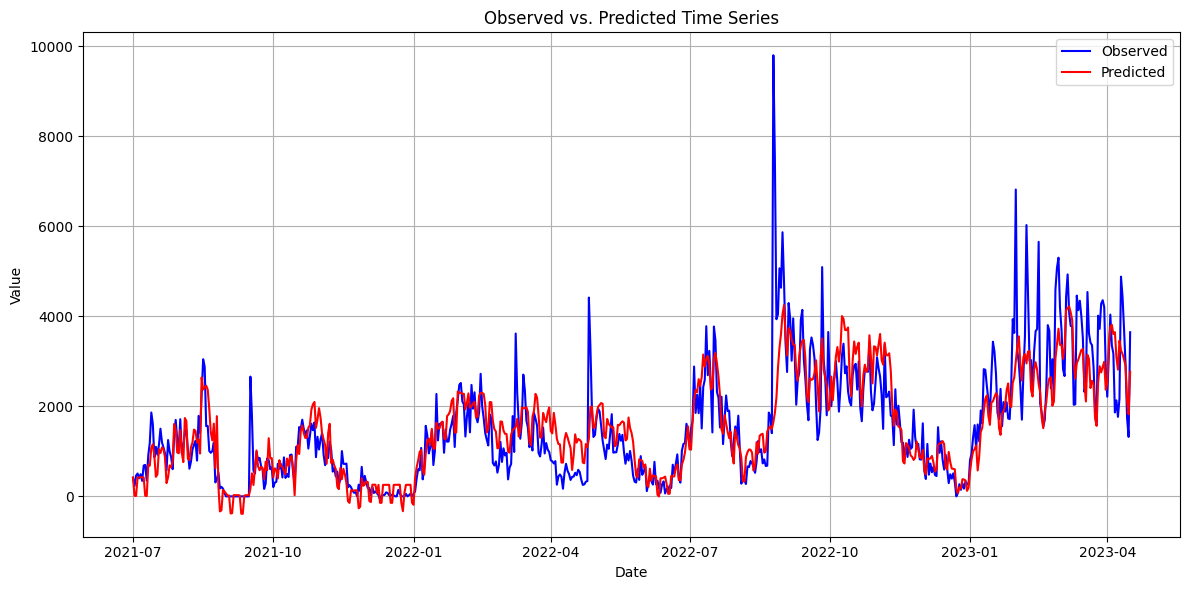

In [ ]:
# Extract the date index, observed values, and predicted values
date_index = train_df.index
y_true = train_df['total_sales']
y_pred = best_pipeline.predict(train_df)

# Create a line plot for observed values (blue)
plt.figure(figsize=(12, 6))  # Optional: Adjust the figure size
plt.plot(date_index, y_true, linestyle='-', color='blue', label='Observed')

# Create a line plot for predicted values (red)
plt.plot(date_index, y_pred, linestyle='-', color='red', label='Predicted')

# Customize the plot
plt.title('Observed vs. Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

# Add a legend to differentiate between observed and predicted lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Test Set

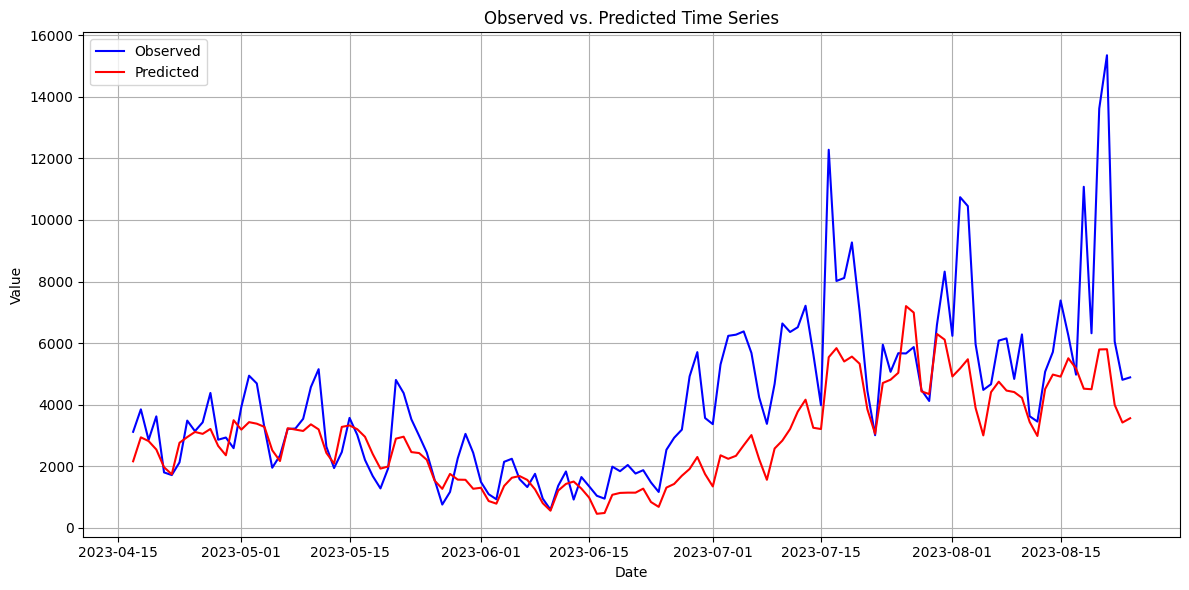

In [ ]:
# Extract the date index, observed values, and predicted values
date_index = test_df.index
y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)

# Create a line plot for observed values (blue)
plt.figure(figsize=(12, 6))  # Optional: Adjust the figure size
plt.plot(date_index, y_true, linestyle='-', color='blue', label='Observed')

# Create a line plot for predicted values (red)
plt.plot(date_index, y_pred, linestyle='-', color='red', label='Predicted')

# Customize the plot
plt.title('Observed vs. Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

# Add a legend to differentiate between observed and predicted lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Check Contributions

In [ ]:
def plot_learning_curve(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=tscv, train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Test score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()
    
    return plt

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

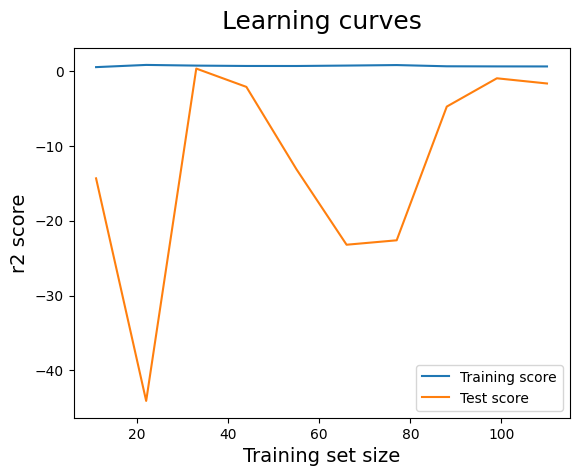

In [ ]:
plot_learning_curve(best_pipeline, 'learning curve', X_train, y_train, cv = tscv)

## Check pipeline output

In [ ]:
pipe_df = pd.DataFrame(best_pipeline[0].transform(X_train))
pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df

,holiday,weekend,sin_months,cos_months,adstock_fb,adstock_gg,adstock_tt
0,0.0,0.0,-0.500000,-0.866025,418.260462,8.767484,6.636967
1,0.0,1.0,-0.500000,-0.866025,406.556631,9.289482,6.636967
2,0.0,1.0,-0.500000,-0.866025,403.578832,9.009530,6.636967
3,0.0,0.0,-0.500000,-0.866025,420.077152,8.532172,6.636967
4,0.0,0.0,-0.500000,-0.866025,419.063910,8.322080,6.636967
...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,1599.331780,352.996129,92.004704
651,0.0,0.0,0.866025,-0.500000,1593.099275,317.282502,91.910878
652,0.0,1.0,0.866025,-0.500000,1164.915382,276.794904,93.334215
653,0.0,1.0,0.866025,-0.500000,824.299353,245.577795,98.529702


## Check for collinearity

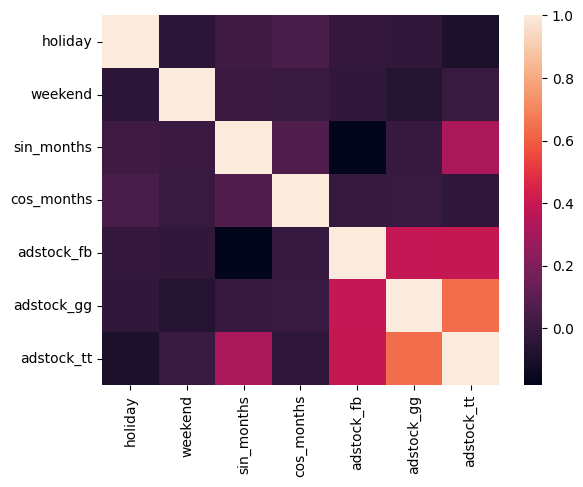

In [ ]:
sns.heatmap(pipe_df.corr());

## Fit and Score on Test

In [ ]:
best_pipeline.fit(X_train, y_train)
f"R-squared: {best_pipeline.score(X_test, y_test)}"

'R-squared: 0.38024241000944925'

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

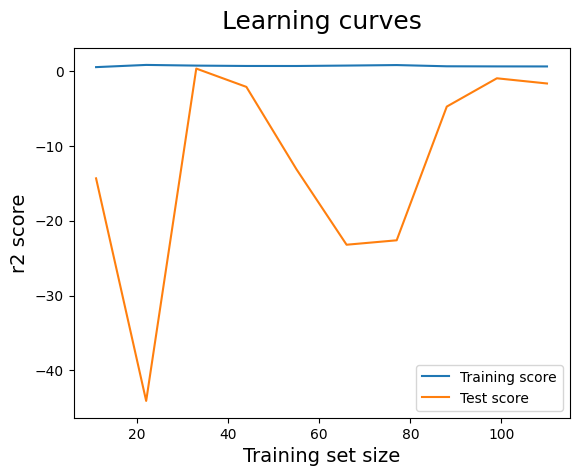

In [ ]:
plot_learning_curve(best_pipeline, 'learning curve', X_train, y_train, cv = 3)

### Check errors

#### Test data

In [ ]:
y_true = test_df['total_sales']
y_pred = best_pipeline.predict(X_test)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(X_test, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.38024241000944925, MAE: 1350.588454601714, RMSE: 2082.2705803912822'

#### Train data

In [ ]:
y_true = train_df['total_sales']
y_pred = best_pipeline.predict(X_train)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(X_train, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.6810208528533321, MAE: 456.6125851582648, RMSE: 725.6279899893926'